In [1]:
import pandas as pd
import numpy as np
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import time
from time import sleep

def get_distance_from_paydays(date):
    end_of_month = date.daysinmonth
    distance_to_1st = 0 if date.day >=15 else 15 - date.day
    distance_to15th = 0 if date.day < 15 else end_of_month - date.day
    return distance_to_1st + distance_to15th

def std(x): return np.std(x)

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            if str(col_type) == numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            if str(col_type)[:5] == 'float':
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


In [2]:
if True:
    df_train = pd.read_csv('../../dataset/train/train_converted.csv')
    df_test  = pd.read_csv('../../dataset/test/test_converted.csv')
    df_train = df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()
    df_test = df_test[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()

else:

    df_train = pd.read_pickle('../../dataset/train/train_converted_fill.pkl')
    df_test  = pd.read_pickle('../../dataset/test/test_converted_fill.pkl')

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)


df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

Memory usage of dataframe is 107.97 MB
Memory usage after optimization is: 33.78 MB
Decreased by 68.7%
Memory usage of dataframe is 21.59 MB
Memory usage after optimization is: 4.08 MB
Decreased by 81.1%


In [3]:
print('Creating date_block_num ...')
N_submission = df_test.shape[0]
N_sales      = df_train.shape[0]

print(df_train.shape,df_test.shape)

dates = (set(df_train['Z_WEEK'].unique()) | set(df_test['Z_WEEK'].unique()))#df_auxiliar['Z_WEEK'].unique()
dates = sorted(dates)

dict_dates = {}
for idx,date in enumerate(dates):
    dict_dates[date] =idx
    
    
df_train['date_block_num'] = df_train['Z_WEEK'].map(dict_dates)
df_test['date_block_num'] = df_test['Z_WEEK'].map(dict_dates)

df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

print('Creating date_block_num completed!')


print('Preprocessing TRAINING DATASET ...')


df_train['Z_WEEK_DATE'] = pd.to_datetime(df_train['Z_WEEK_DATE'])
df_train['days_from_payday'] = df_train['Z_WEEK_DATE'].apply(get_distance_from_paydays)


statistics_columns = [ ]

df_train["log_Demanda"] = np.log(df_train['Demanda'] + 1e-8)
#df_test["log_Demanda"] = np.log(1e-8)

statistics_columns.append('log_Demanda')

#'''
bar1 = tqdm([
    ['Z_MODELO'],
    ['Z_PUNTO_VENTA'],
    ['Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA'],
    ['Z_MODELO','Z_GAMA'],
    ['Z_PUNTO_VENTA','Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']], position=0, desc="i",colour='green', ncols=80)
time.sleep(1)

bar2 = tqdm(['mean'], position=1, desc="j", colour='red', ncols=80, leave=False) #'std','max','min','sum'
time.sleep(1)

unique_columns = [ ]
        
for column_names in bar1:
    bar1.update()
    bar2.refresh()  #force print final state
    time.sleep(0.1)
    bar2.reset()  #reuse bar
    for statistic in bar2:
        
        new_column_name = statistic+'_sales_by_'+'_'.join(column_names)
        #df_train[new_column_name] = df_train.groupby(["Z_WEEK_DATE"]+column_names, observed=True).Demanda.transform(statistic)
        if statistic == 'mean':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.mean()
        if statistic == 'std':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.std(ddof=0)
        if statistic == 'max':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.max()
        if statistic == 'min':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.min()
        if statistic == 'sum':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.sum()        
        if df_agg.shape[0] >= df_train.shape[0]*0.7:
            unique_columns.append([["Z_WEEK"]+column_names,new_column_name])
            continue
        
        df_agg = df_agg.reset_index()
        df_agg.columns = df_agg.columns.str.replace('Demanda', new_column_name)
        
        df_train = df_train.merge(df_agg,on=["Z_WEEK"]+column_names,how='left')
        statistics_columns.append(new_column_name)
        bar2.update()
        time.sleep(0.05)
#'''
df_train['dayofweek'] = df_train['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
df_train['month'] = df_train['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
df_train['dayofyear'] = df_train['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')

df_train.drop(columns=['Z_WEEK_DATE'],inplace=True)
df_train.drop(columns=['Z_WEEK'],inplace=True)

print('Preprocessing TRAINING DATASET COMPLETED!')
print('Preprocessing TESTING DATASET ...')


df_test['Z_WEEK_DATE'] = pd.to_datetime(df_test['Z_WEEK_DATE'])
df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)

inv_dict_dates = {v: k for k, v in dict_dates.items()}
#df_test['Z_WEEK'] = df_test['date_block_num'].map(inv_dict_dates)
df_test = df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda","Z_WEEK_DATE"]]

df_test['dayofweek'] = df_test['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
df_test['month'] = df_test['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
df_test['dayofyear'] = df_test['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')



df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)
df_test.drop(columns=['Z_WEEK_DATE'],inplace=True)

print('Preprocessing TESTING DATASET COMPLETED!')


Creating date_block_num ...
(2358650, 6) (471730, 6)
Creating date_block_num completed!
Preprocessing TRAINING DATASET ...


i: 100%|██████████████████████████████████████████| 7/7 [00:07<00:00,  1.09s/it]


Preprocessing TRAINING DATASET COMPLETED!
Preprocessing TESTING DATASET ...
Preprocessing TESTING DATASET COMPLETED!


In [4]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 182.24 MB
Memory usage after optimization is: 101.26 MB
Decreased by 44.4%


In [5]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 5.43 MB
Memory usage after optimization is: 5.43 MB
Decreased by 0.0%


In [6]:
#%timeit df_train.to_pickle('../../dataset/train/train_converted_fill_process.pkl')

In [7]:
#%timeit df_test.to_pickle('../../dataset/test/test_converted_fill_process.pkl')

In [8]:
print(df_train.shape)
#print(list(df_train.columns))
df_train.head(2)

(2358650, 15)


,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Demanda,date_block_num,days_from_payday,log_Demanda,mean_sales_by_Z_MODELO,mean_sales_by_Z_PUNTO_VENTA,mean_sales_by_Z_GAMA,mean_sales_by_Z_MODELO_Z_GAMA,mean_sales_by_Z_PUNTO_VENTA_Z_GAMA,dayofweek,month,dayofyear
0,MOD_1,PVENT_1,GAM_1,0,0,14,-18.421875,0.0,10.757812,1.141602,0.0,21.359375,0,5,137
1,MOD_1,PVENT_1,GAM_1,0,1,7,-18.421875,0.0,12.703125,1.191406,0.0,26.218750,0,5,144


In [9]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,EncoderNormalizer

from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
# configure network and trainer
pl.seed_everything(42)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_

In [10]:
prediction_steps = df_test['date_block_num'].nunique()
prediction_steps

10

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2358650 entries, 0 to 2358649
Data columns (total 15 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   Z_MODELO                            category
 1   Z_PUNTO_VENTA                       category
 2   Z_GAMA                              category
 3   Demanda                             int64   
 4   date_block_num                      category
 5   days_from_payday                    int64   
 6   log_Demanda                         float16 
 7   mean_sales_by_Z_MODELO              float16 
 8   mean_sales_by_Z_PUNTO_VENTA         float16 
 9   mean_sales_by_Z_GAMA                float16 
 10  mean_sales_by_Z_MODELO_Z_GAMA       float16 
 11  mean_sales_by_Z_PUNTO_VENTA_Z_GAMA  float16 
 12  dayofweek                           category
 13  month                               category
 14  dayofyear                           category
dtypes: category(7), float16(6), int6

In [12]:
df_train['date_block_num'] = df_train['date_block_num'].astype(int)
df_test['date_block_num'] = df_test['date_block_num'].astype(int)

In [13]:
df_train['Demanda'] = df_train['Demanda'].astype(np.float16)
df_test['Demanda'] = df_test['Demanda'].astype(np.float16)

In [14]:
for column in df_train.columns:
    print(column,'train',df_train[df_train[column]==358].shape)
    if column in df_test.columns:
        print(column,'test ',df_test[df_test[column]==358].shape)

Z_MODELO train (0, 15)
Z_MODELO test  (0, 9)
Z_PUNTO_VENTA train (0, 15)
Z_PUNTO_VENTA test  (0, 9)
Z_GAMA train (0, 15)
Z_GAMA test  (0, 9)
Demanda train (1, 15)
Demanda test  (0, 9)
date_block_num train (0, 15)
date_block_num test  (0, 9)
days_from_payday train (0, 15)
days_from_payday test  (0, 9)
log_Demanda train (0, 15)
mean_sales_by_Z_MODELO train (0, 15)
mean_sales_by_Z_PUNTO_VENTA train (0, 15)
mean_sales_by_Z_GAMA train (0, 15)
mean_sales_by_Z_MODELO_Z_GAMA train (0, 15)
mean_sales_by_Z_PUNTO_VENTA_Z_GAMA train (0, 15)
dayofweek train (0, 15)
dayofweek test  (0, 9)
month train (0, 15)
month test  (0, 9)
dayofyear train (0, 15)
dayofyear test  (0, 9)


In [15]:
df_train.head(2)

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Demanda,date_block_num,days_from_payday,log_Demanda,mean_sales_by_Z_MODELO,mean_sales_by_Z_PUNTO_VENTA,mean_sales_by_Z_GAMA,mean_sales_by_Z_MODELO_Z_GAMA,mean_sales_by_Z_PUNTO_VENTA_Z_GAMA,dayofweek,month,dayofyear
0,MOD_1,PVENT_1,GAM_1,0.0,0,14,-18.421875,0.0,10.757812,1.141602,0.0,21.359375,0,5,137
1,MOD_1,PVENT_1,GAM_1,0.0,1,7,-18.421875,0.0,12.703125,1.191406,0.0,26.218750,0,5,144


In [16]:
#'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start', 
# 'I103','S103', 'C101','I100' , 'C100', 'ID', 'I102','S102',, 'S101', 'S100', 'item_id', 'date_block_num', 'I101'
max_prediction_length = prediction_steps

max_encoder_length = 40

training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="Demanda",
    group_ids=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    min_encoder_length= max_encoder_length // 2,   
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
        
    static_categoricals=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    
    time_varying_known_categoricals=[
                                     "month", 
                                     "dayofweek",
                                     "dayofyear"],
    
    time_varying_known_reals=["date_block_num",'days_from_payday'],
    time_varying_unknown_categoricals=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],  
    time_varying_unknown_reals= statistics_columns+['date_block_num'],#'Demanda',  statistics_columns+['Demanda'],#'date_block_num'],
       
    #target_normalizer=GroupNormalizer(
    #    groups=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'], transformation="softplus"
    #),  # use softplus and normalize by group    
    
    categorical_encoders={                          
                          "Z_GAMA":  pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_MODELO": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_PUNTO_VENTA": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "dayofweek": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "dayofyear": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "date_block_num": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

In [17]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)

val_dataloader   = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=3)

In [18]:
from pytorch_forecasting.metrics import MultiHorizonMetric
from typing import Dict, List, Tuple, Union
from pytorch_forecasting.metrics import TweedieLoss,NegativeBinomialDistributionLoss,BetaDistributionLoss
from pytorch_lightning.callbacks import ModelCheckpoint
'''
def tweedieloss(y_true, y_pred):
    p=1.5
    a = K.pow(y_true, 2-p)/((1-p) * (2-p))
    b = K.pow(y_pred, 1-p)/(1-p)
    c = K.pow(y_pred, 2-p)/(2-p)
    dev = 2 * (a -y_true *b  +c)
    return K.mean(dev)
'''
class new_tweedieloss(MultiHorizonMetric):
    def __init__(self, reduction="none", **kwargs):
        super().__init__(reduction=reduction, **kwargs)
    def loss(self, y_pred: Dict[str, torch.Tensor], target):
        p = 1.5#torch.tensor([1.01], dtype=torch.float16)
        eps = 1e-10
        
        factor = 1
        
        if y_pred.sum() <= eps:
            print("wtahsd!!")
            factor = 1e19
            # y_pred = np.random.rand(len(y_pred))
        else:
            # y_pred = np.where(y_pred<0, eps, y_pred)  #Filter 0 and negative values 
            y_pred = torch.abs(y_pred)
        #.requires_grad_(True)
        preds = self.to_prediction(y_pred) + eps
        #'''
        
        a = target*(torch.pow(preds,1-p))/(1-p)
        b = torch.pow(preds,2-p)/(2-p)
        tweddie = torch.mean((-a+b)/factor)
        '''
        a = torch.pow(target, 2-p)/((1-p) * (2-p))
        b = torch.pow(preds, 1-p)/(1-p)
        c = torch.pow(preds, 2-p)/(2-p)
        tweddie = -2 * (a -target *b  +c)
        '''
        return tweddie

In [19]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Quadro RTX 5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [20]:

trainer = pl.Trainer(gpus=1,gradient_clip_val=0.1)
trainer.enforce_positive_output=True

tft = TemporalFusionTransformer.from_dataset(
    training,

    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss = new_tweedieloss(),#.to(device),    
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 40.2k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr:  75%|███████▌  | 75/100 [00:13<00:04,  6.08it/s]

wtahsd!!
wtahsd!!


Finding best initial lr: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]
Restoring states from the checkpoint path at /notebooks/entel-2022/DATATHON-ENTEL-2022---Reto2/notebooks/cristian/.lr_find_953a17e4-0eaf-4253-b63a-1905d672b371.ckpt


suggested learning rate: 5.248074602497725e-07


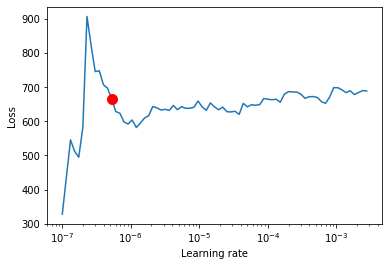

In [21]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [22]:
res.suggestion()

5.248074602497725e-07

In [23]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= res.suggestion(),
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1, 
    loss = new_tweedieloss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 39.8k


In [24]:
#Early Stopping 
MIN_DELTA  = 1e-7
PATIENCE   = 30

#PL Trainer
MAX_EPOCHS = 5000

GPUS = 1



# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='epoch')  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard



checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='../../results/models/tft/',
    filename='MODEL_tft-tweedie-loss-epoch_{epoch:02d}-val_loss_{val_loss:.3f}',
    auto_insert_metric_name=False,
    
 )

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=GPUS,
    #weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,#oment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback,checkpoint_callback],
    #log_every_n_steps=10,
    logger=logger,
)
trainer.enforce_positive_output=True


print('holas')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


holas


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | new_tweedieloss                 | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 13.5 K
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Epoch 0:  45%|████▍     | 30/67 [00:05<00:06,  5.30it/s, loss=643, v_num=23, train_loss_step=912.0]  
Validation: 0it [00:00, ?it/s]
Epoch 0:  60%|█████▉    | 40/67 [00:10<00:07,  3.78it/s, loss=643, v_num=23, train_loss_step=912.0]wtahsd!!
wtahsd!!

Epoch 1:  45%|████▍     | 30/67 [00:05<00:07,  5.13it/s, loss=994, v_num=23, train_loss_step=555.0, val_loss=901.0, train_loss_epoch=622.0]       
Validation: 0it [00:00, ?it/s]
Epoch 1:  60%|█████▉    | 40/67 [00:11<00:07,  3.57it/s, loss=994, v_num=23, train_loss_step=555.0, val_loss=901.0, train_loss_epoch=622.0]wtahsd!!
wtahsd!!

Epoch 2:  45%|████▍     | 30/67 [00:05<00:07,  5.08it/s, loss=906, v_num=23, train_loss_step=731.0, val_loss=901.0, train_loss_epoch=930.0]       
Validation: 0it [00:00, ?it/s]
Epoch 2:  60%|█████▉    | 40/67 [00:11<00:07,  3.63it/s, loss=906, v_num=23, train_loss_step=731.0, val_loss=901.0, train_loss_epoch=930.0]wtahsd!!
wtahsd!!

Epoch 3:  45%|████▍     | 30/67 [00:06<00:07,  4.89it/s, loss=774, v_num=23, 

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(best_model_path)
best_model_name = best_model_path.split('/')[-1]
print('best_model_name = ',best_model_name)

In [ ]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)
criterion = nn.MSELoss()
rmse_val = torch.sqrt(criterion(actuals,val_predictions)).item()
print('rmse_val = ',rmse_val)
#rmse_val =  4.774808883666992

In [ ]:
print('max_prediction_length:',max_prediction_length)
print('max_encoder_length   :',max_encoder_length)

In [ ]:
# select last 30 days from data (max_encoder_length is 24)
encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]

print(encoder_data['date_block_num'].min(),encoder_data['date_block_num'].max())
#print(encoder_data['DATE'].min(),encoder_data['DATE'].max())
encoder_data

In [ ]:

last_data = df_train[df_train['date_block_num'].isin([idx  -  max_prediction_length for idx in df_test['date_block_num'].unique()])]
last_data['date_block_num'] = last_data['date_block_num'] + max_prediction_length

decoder_data = pd.merge(df_test[[col for col in df_test.columns if 'Demanda' not in col]], 
        last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda"]+statistics_columns],
        on = ['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',],
                        how='left'
        )


encoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
decoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)


# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda"]+statistics_columns]

In [ ]:
import matplotlib.pyplot as plt

aux = encoder_data['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

aux = decoder_data['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [ ]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="prediction", return_x=False)

In [ ]:
predictions = pd.DataFrame(new_raw_predictions.numpy()).T
predictions['date_block_num'] = sorted(df_test['date_block_num'].unique())
predictions = pd.melt(predictions, id_vars=['date_block_num'])
predictions = predictions.sort_values(['date_block_num', 'variable']).reset_index(drop=True)
df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']].sort_values(['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']).reset_index(drop=True)
df_test2 = df_test.join(predictions['value'])

In [ ]:
df_test2.head()

In [ ]:
import pickle

reverse_mapping_file = '../../utils/reverse_dict_mapping_list.txt'

with open(reverse_mapping_file, 'rb') as f:
    reverse_mapping = pickle.load( f)

In [ ]:
#reverse_mapping#

In [ ]:
#descriptive_columns = ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']
descriptive_columns = ['Z_MARCA', 'Z_GAMA', 'Z_MODELO',
                       'Z_DEPARTAMENTO', 'Z_PUNTO_VENTA']
i=0
for column in descriptive_columns:
    if column in df_test2.columns:
        df_test2[column] = df_test2[column].map(reverse_mapping[i])
    i+=1

In [ ]:
df_test2.head()

In [ ]:

inv_dict_dates = {v: k for k, v in dict_dates.items()}
df_test2['Z_WEEK'] = df_test2['date_block_num'].map(inv_dict_dates)

In [ ]:
for column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']:
    df_test2[column] = df_test2[column].astype(str)

In [ ]:
df_test2['ID'] = df_test2['Z_MODELO'] + '|' + df_test2['Z_PUNTO_VENTA'] + '|' + df_test2['Z_GAMA'] + '|' + df_test2['Z_WEEK']

In [ ]:
df_test2['Demanda'] = np.maximum(df_test2['value'],0)
submission = df_test2[['Z_WEEK','ID','Demanda']]#.groupby('ID').sum().reset_index()

In [ ]:
submission

In [ ]:
submission.boxplot(['Demanda'])

In [ ]:
import matplotlib.pyplot as plt

aux = df_train['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

prediction = submission['Demanda'].values
df_baseline = pd.read_csv('../../results/Submission_37.csv')
real = df_baseline['Demanda']


y_actual = df_baseline['Demanda']
y_predicted = submission['Demanda'].values

rms = mean_squared_error(y_actual, y_predicted, squared=False)
rms

In [ ]:


fig = plt.figure(figsize=(30,5),facecolor='white')

plt.subplot(3,1,1)
plt.plot(prediction,'bo')
plt.title('prediction')


plt.subplot(3,1,2)
plt.plot(real,'go')
plt.title('real')

plt.subplot(3,1,3)
plt.plot(prediction,'bo',alpha=0.7,label='prediction')
plt.plot(real,'go',alpha=0.1,label='real')
plt.title('real')

plt.suptitle(best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_PREDICTIONS')
plt.show()

fig.savefig(
            '../../results/models/tft/'+best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_PREDICTIONS.png') 

In [ ]:
aux[aux>=300]

In [ ]:
from sklearn.metrics import mean_squared_error

y_actual = df_baseline['Demanda']
y_predicted = submission['Demanda'].values

rms = mean_squared_error(y_actual, y_predicted, squared=False)
rms

In [ ]:
#rmse_val = 3
submission['Demanda_real'] = df_baseline['Demanda']

import plotly.express as px

tendencia_semanal = submission[['Z_WEEK','Demanda','Demanda_real']].groupby(['Z_WEEK']).sum().reset_index()

graph = pd.melt(tendencia_semanal,id_vars=['Z_WEEK'],value_vars=['Demanda','Demanda_real'],)

#fig = px.line(graph,x='Z_WEEK',y='value',color='variable')
#fig.show()
import seaborn as sns
sns.set(style='white')
sns_fig = sns.catplot(x="Z_WEEK", y="value", hue="variable", kind="point", data=graph, height=4.27, aspect=25.7/8.27,facecolor='w')
plt.title(best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_DEMANDA_SEMANAL_TOTAL')
fig = sns_fig.figure
fig.savefig(
            '../../results/models/tft/'+best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_DEMANDA_SEMANAL_TOTAL.png') 

In [ ]:
#submission['Demanda'] = 0.9#submission['value']
import numpy as np

submission[['ID', 'Demanda']].to_csv('../../results/models/tft/'+best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_SUBMISSION.csv', index = False, sep = ',')

In [ ]:
submission.head(1)